# Model Evaluation

In [1]:
# imports
import sys
BASE_PATH =  "/Users/audreymcmillion/Documents/acm-thesis"
sys.path.append(BASE_PATH) 
import duckdb
import matplotlib.pyplot as plt
from model_fitting import ModelFitting
from ev_scoring import ExtremeValueScoring
from market_utils import MarketUtilities
import pandas as pd
from tqdm import tqdm
import json 

ev = ExtremeValueScoring(wrds_username='audreymcmillion')
db = ev.wrds_db
conn = ev.sqlite_conn
mkt_utils = MarketUtilities(wrds_username='audreymcmillion', wrds_db = db, sqlite_conn = conn)

Loading library list...
Done


In [88]:
def get_ordered_models(df, name_col = "model"):
    # Get unique models and categorize
    model_names = sorted(df[name_col].unique().tolist(), reverse=True)
    gamma_models = [m for m in model_names if "gamma" in m.lower()]
    residual_models = [m for m in model_names if "residual" in m.lower()]
    garch_models = [m for m in model_names if "ar(1)-garch(1,1)" in m.lower() and m not in gamma_models and m not in residual_models]
    other_models = [m for m in model_names if m not in gamma_models + residual_models + garch_models]

    # Build ordered list
    ordered_models = gamma_models + residual_models + garch_models + other_models
    return ordered_models, (gamma_models, residual_models, garch_models, other_models)

In [89]:
dist_shift_query = """
    SELECT 
        t.*,
        ROW_NUMBER() OVER (PARTITION BY symbol ORDER BY chunk_end_date) AS rn
    FROM iterative_ev_kl_5D t
    WHERE chunk_start_date > '2000-01-01'
    AND kl_divergence > 0.5
    AND chunk_end_date > '2020-01-31'
  """
ex_distshift_df = pd.read_sql(dist_shift_query, conn)

In [90]:
ex_distshift_df

,index,symbol,chunk_start_date,chunk_end_date,kl_divergence,top5_flag,rn
0,1172,AAL,2019-06-27,2020-04-13,inf,0,1
1,1661,ACNB,2019-06-28,2020-04-14,inf,1,1
2,2412,ALTY,2019-06-27,2020-04-13,1.205676,1,1
3,2413,ALTY,2019-07-12,2020-04-27,inf,1,2
4,3783,ANAT,2019-07-08,2020-04-21,inf,0,1
...,...,...,...,...,...,...,...
100,60722,VSMV,2019-05-20,2020-03-04,0.686753,1,1
101,60765,VTC,2019-06-04,2020-03-18,inf,1,1
102,62177,WHF,2019-05-31,2020-03-16,inf,1,1
103,62179,WHF,2019-06-28,2020-04-14,inf,1,2


In [91]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import matplotlib.colors as mcolors

eval_template = """
    with garch_vals as (
    	select symbol, test_set, model, count(*) as garch_count
    	from argarch_results ar 
    	where model = 'AR(1)-GARCH(1,1)'
    	group by 1, 2, 3
    	HAVING count(*) >= 100
    ),
    
    dtaci_vals as (
    	SELECT symbol, conformity_score, test_set, model, count(*) as dtaci_count
    	from dtaci_results_new drn 
    	where conformity_score = 'residual_normalized'
    	and model =  'AR(1)-GARCH(1,1)'
    	group by 1, 2, 3, 4
    	HAVING count(*) >= 100
    ),
    
    common_records as (
    	SELECT gv.symbol
    	FROM garch_vals gv
    	join dtaci_vals dv
    	where (gv.symbol, gv.test_set) = (dv.symbol, dv.test_set)
    )
    
    select * 
    from model_coverage_stats2
    where test_set = '{test_set}'
    and (model = 'AR(1)-GARCH(1,1)' or base_model in ('AR(1)-GARCH(1,1)', 'AR(1)')) 
    and symbol in (select distinct symbol from common_records)
    order by model
    """

def break_label(label):
    parts = label.split()
    if len(parts) > 2:
        return " ".join(parts[:2]) + "<br>" + " ".join(parts[2:])
    else:
        return label

def get_data(test_set):
    if test_set == 'Real Distribution Shift (in Extreme)':
        df = pd.read_sql(eval_template.format(test_set='Real Distribution Shift'), conn)
        dist_shift_query = """
            SELECT 
                t.*,
                ROW_NUMBER() OVER (PARTITION BY symbol ORDER BY chunk_end_date) AS rn
            FROM iterative_ev_kl_5D t
            WHERE chunk_start_date > '2000-01-01'
            AND kl_divergence > 0.5
            AND chunk_end_date > '2020-01-31'
          """
        ex_distshift_df = pd.read_sql(dist_shift_query, conn)
        ex_symbols = list(ex_distshift_df["symbol"].unique())
        return df[df['symbol'].isin(ex_symbols)] #.reset_index(drop=True)
    else:
         df = pd.read_sql(eval_template.format(test_set=test_set), conn)
         return df

def to_rgb_tuple(color_str):
    """Convert Plotly color string (hex or 'rgb(...)') to RGB tuple."""
    if color_str.startswith("rgb"):
        nums = color_str.strip("rgb()").split(",")
        return tuple(int(n) / 255 for n in nums)
    else:
        return mcolors.to_rgb(color_str)
        
def darken_palette(palette, factor=0.85):
    darkened = []
    for color_str in palette:
        rgb = to_rgb_tuple(color_str)
        dark_rgb = tuple(max(0, c * factor) for c in rgb)
        darkened.append(mcolors.to_hex(dark_rgb))
    return darkened

def create_boxplots(
    test_set: str,
    x_columns=["coverage", "avg_width", "mwi_score", "cwc_score"],
    eval_template=eval_template
):
    df = get_data(test_set)
        
    df_display = df.copy()
    df_display["model_wrapped"] = df_display["model"].apply(break_label)

    # Build ordered list
    ordered_models, components = get_ordered_models(df_display)
    gamma_models, residual_models, garch_models, other_models = components

    # Color maps
    blue_palette = px.colors.sequential.Blues[1::2][1:]
    green_palette = px.colors.sequential.Greens[1:]
    # green_palette = darken_palette(green_palette, factor=0.9)
    
    color_map = {}
    for i, m in enumerate(gamma_models):
        color_map[m] = blue_palette[i]
    for i, m in enumerate(residual_models):
        if "DtACI" in m:
            color_map[m] = green_palette[i]
    for m in garch_models:
        color_map[m] = "darkred"

    color_map['OC: Residual Normalized Score'] = '#CC5500'
    color_map['NC: Residual Normalized Score'] = '#FFD580'


    # Define pretty subplot titles and corresponding x-axis labels
    subplot_labels = {
        "coverage": "Coverage",
        "avg_width": "√(Average Width)",
        "mwi_score": "√(MWI Score)",
        "cwc_score": "√(CWC)"
    }

    fig = make_subplots(
        rows=1,
        cols=len(x_columns),
        shared_yaxes=True,
        subplot_titles=[subplot_labels.get(c, c) for c in x_columns]
    )

    # Plot
    for i, x_col in enumerate(x_columns, start=1):
        for m in ordered_models:
            if "Gamma" in m:
                continue

            temp = df_display[df_display["model"] == m]
            if temp.empty:
                continue

            color = color_map.get(m, "gray")
            x_data = np.sqrt(temp[x_col]) if x_col != "coverage" else temp[x_col]

            trace = go.Box(
                x=x_data,
                y=temp["model_wrapped"],
                name=m,
                orientation="h",
                boxmean=True,
                boxpoints=False,
                marker=dict(color=color),
                showlegend=False
            )

            fig.add_trace(trace, row=1, col=i)

        # Set individual x-axis titles
        fig.update_xaxes(title_text=subplot_labels.get(x_col, x_col), row=1, col=i)

    # Consistent formatting across all subplots
    for i in range(1, len(x_columns) + 1):
        fig.update_xaxes(tickformat=",.1f", row=1, col=i)

    # Layout
    fig.update_layout(
        height=550,
        width=1200,
        showlegend=False,
        title_text=f"Boxplots per Model and Metric for {test_set} Test Set",
        template="ggplot2",
    )

    fig.show()

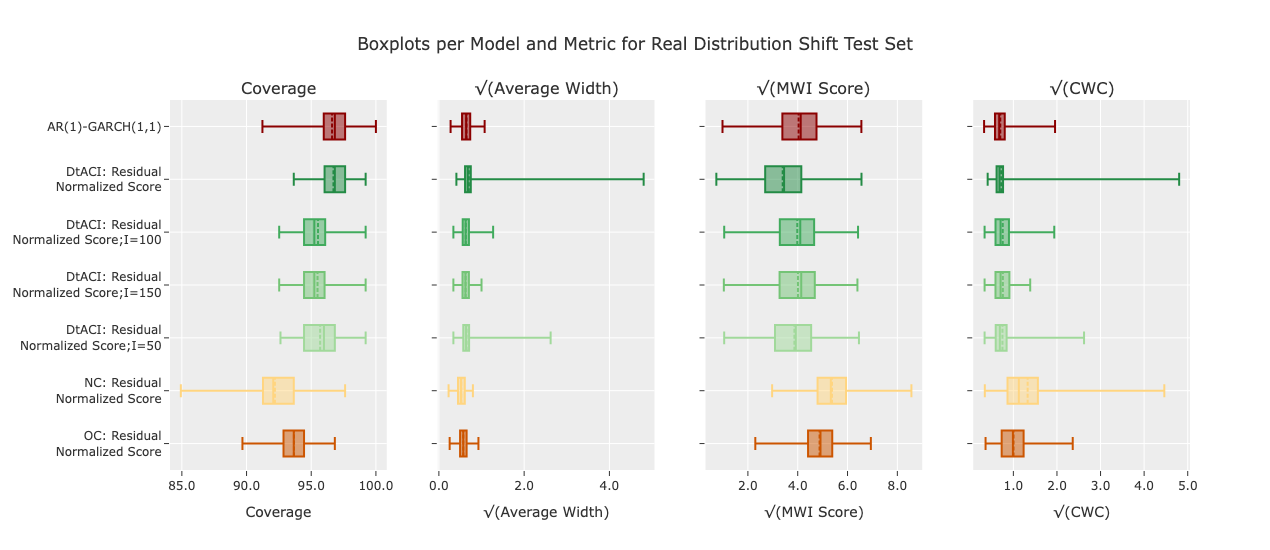

In [92]:
create_boxplots("Real Distribution Shift")

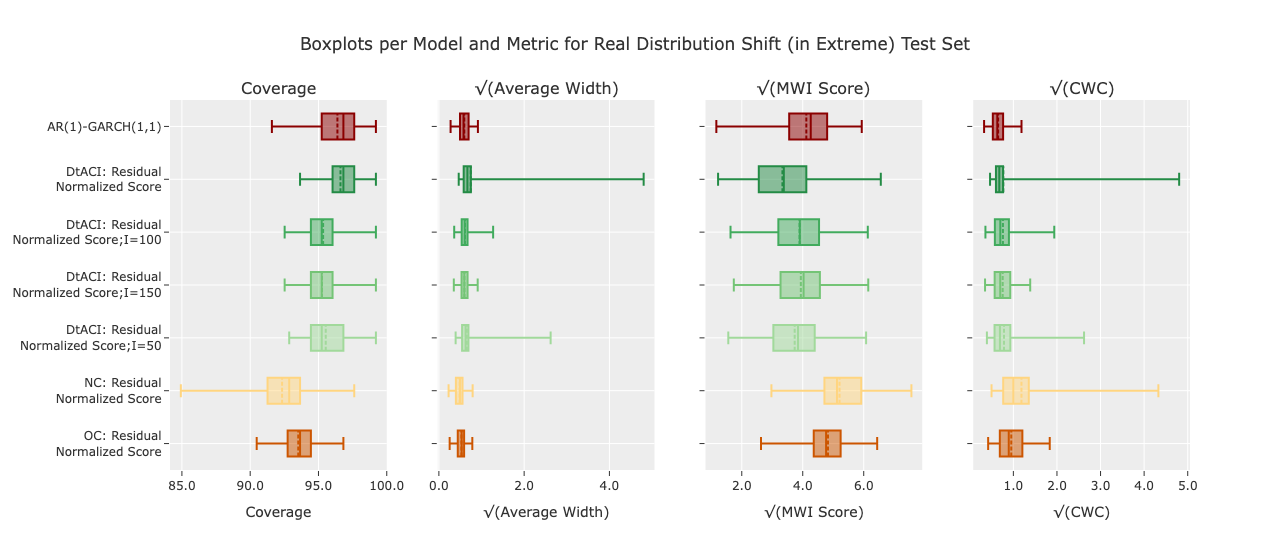

In [93]:
create_boxplots("Real Distribution Shift (in Extreme)")

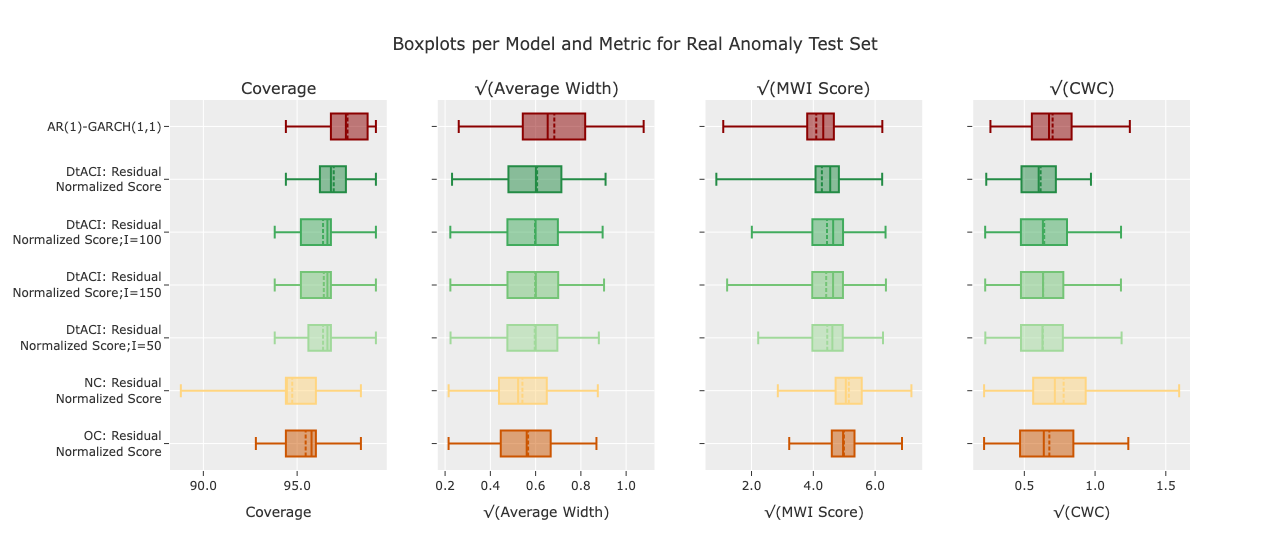

In [94]:
create_boxplots("Real Anomaly")

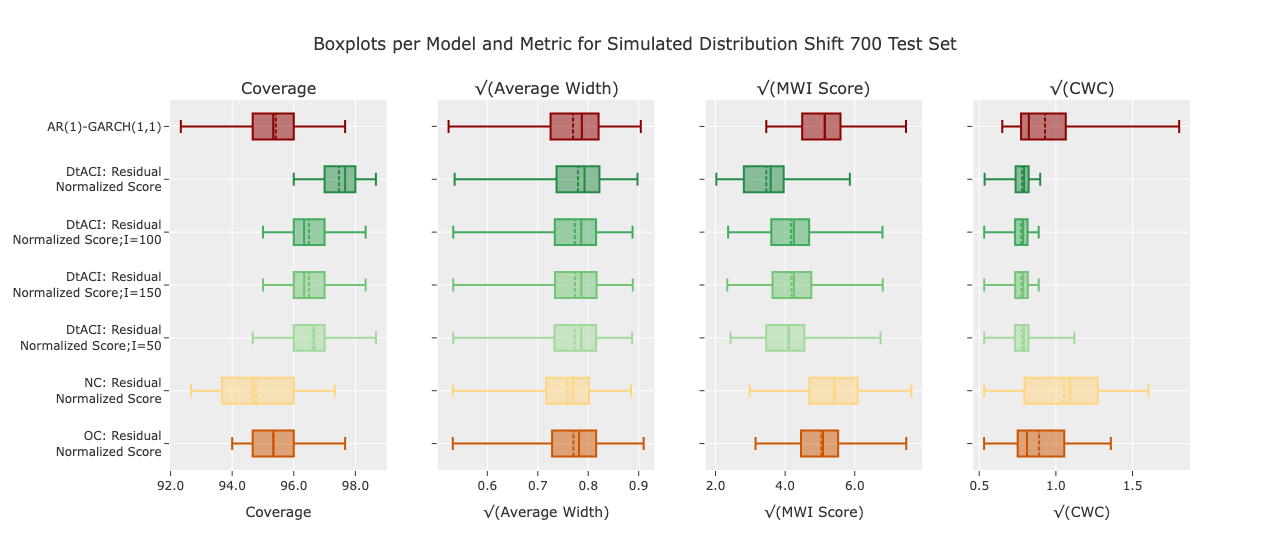

In [95]:
create_boxplots("Simulated Distribution Shift 700")

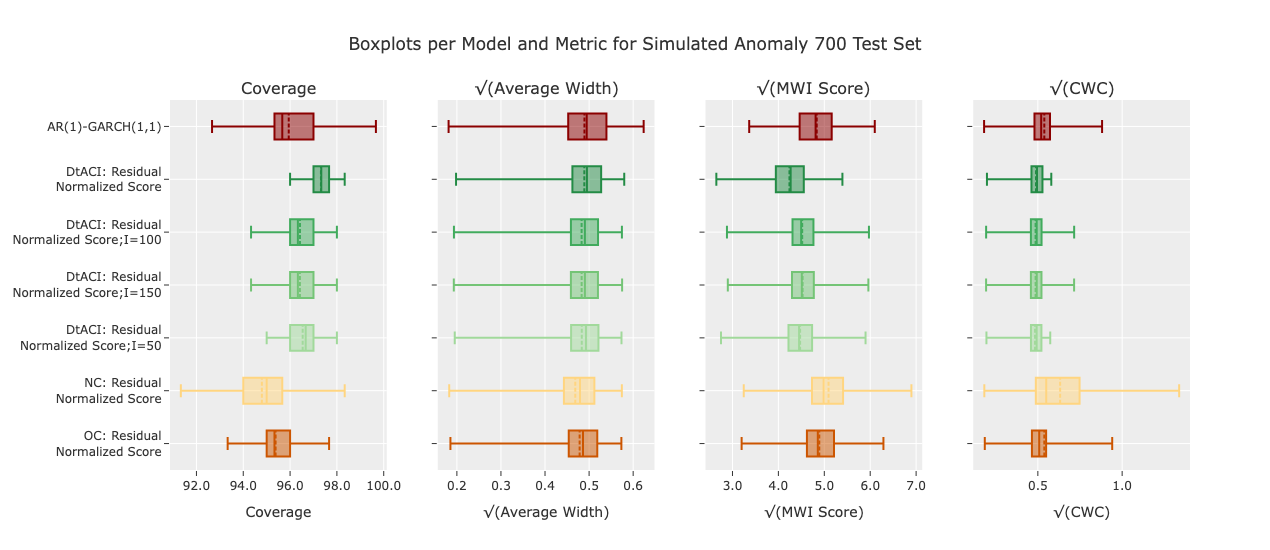

In [96]:
create_boxplots("Simulated Anomaly 700")

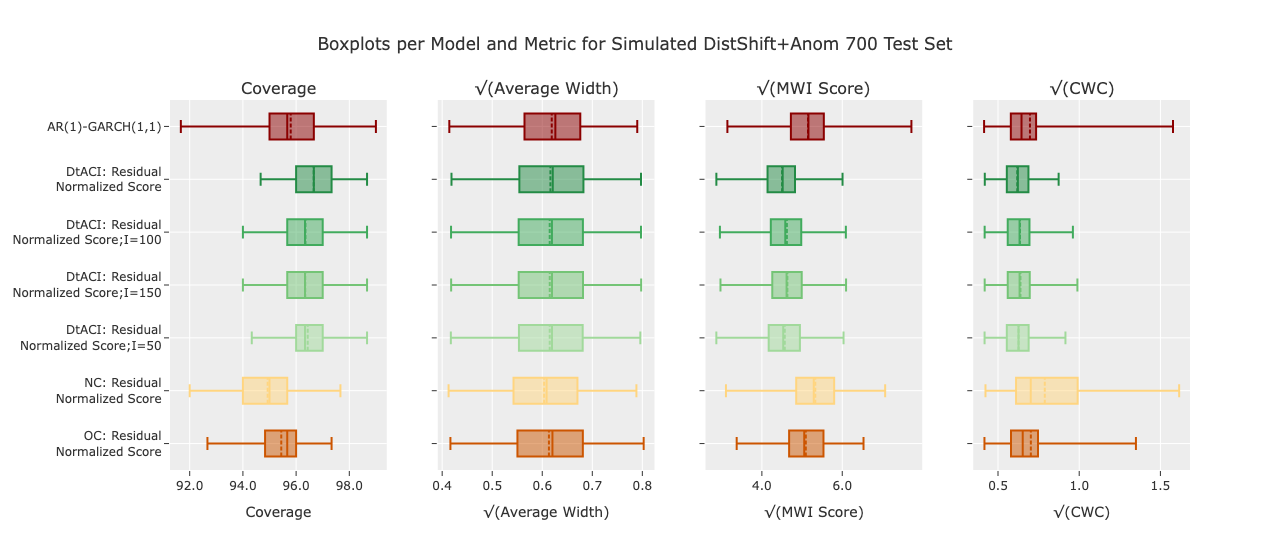

In [97]:
create_boxplots("Simulated DistShift+Anom 700")

In [ ]:
import numpy as np
pd.set_option('display.float_format', '{:.3f}'.format)

test_set = "Simulated DistShift+Anom 700"
df = pd.read_sql(eval_template.format(test_set=test_set), conn)

# Extract std category from symbol, e.g. "AAPL|std=5;6" → "5;6"
df["std_category"] = df["symbol"].str.extract(r"\|std=(.*)$")

# Group by std_category and model, then compute medians
agg_df = (
    df.groupby(["std_category", "model"], as_index=False)
    .agg({
        "avg_width": "median",
        "cwc_score": "median",
        "mwi_score": "median",
        "coverage": "mean"
    })
)

# Rename columns for clarity
agg_df.rename(columns={
    "avg_width": "median_avg_width",
    "cwc_score": "median_cwc_score",
    "mwi_score": "median_mwi_score",
    "coverage": "average_coverage"
}, inplace=True)

# Display or save the result
agg_df
#Create a pivot table
pivot_table = pd.pivot_table(agg_df, values=['median_avg_width', 'median_cwc_score', 'median_mwi_score', 'average_coverage'], 
                             index='std_category', columns='model', aggfunc=np.sum, fill_value=0)
pivot_table

## Smaller Sample Sets

In [ ]:
eval_template_small = """
    select * 
    from model_coverage_stats
    where test_set = '{test_set}'
    and (model = 'AR(1)-ARCH(1)' or base_model in ('AR(1)-ARCH(1) - 200', 'AR(1) - 200')) 
    and symbol in (
        select distinct symbol
    from argarch_results ar 
    where test_set = '{test_set}'
    group by symbol
    having count(*) >= 100
    )
    order by model
    """

In [ ]:
create_boxplots(test_set="Simulated Distribution Shift 700", 
                x_columns=["median_width", "mwi_score", "cwc_score", "coverage"], eval_template = eval_template_small)

## Visualizing bands

In [ ]:
import matplotlib.pyplot as plt

def plot_forecast(forecast_df, level=0.95):
    # Set the target coverage level
    target_coverage = level * 100

    # Identify points outside the confidence interval
    out_of_band = (forecast_df['actual'] < forecast_df['lower_bound']) | (forecast_df['actual'] > forecast_df['upper_bound'])
    
    # Compute empirical coverage
    coverage = 1 - out_of_band.mean()
    coverage_percent = coverage * 100

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(forecast_df['actual'], label='Actual Return', color='black', alpha=0.7)
    plt.plot(forecast_df['forecast'], label='Forecasted Mean', color='orange', linestyle='--')
    plt.fill_between(
        forecast_df.index,
        forecast_df['lower_bound'],
        forecast_df['upper_bound'],
        color='orange',
        alpha=0.2,
        label=f'{target_coverage:.1f}% CI'
    )

    # Add red dots for out-of-band points
    plt.scatter(
        forecast_df.index[out_of_band],
        forecast_df['actual'][out_of_band],
        color='red',
        label='Outside Bands',
        zorder=5
    )

    # Add coverage text (top-left corner)
    plt.text(
        0.01, 0.98,
        f'Empirical coverage: {coverage_percent:.2f}%',
        transform=plt.gca().transAxes,
        fontsize=10,
        verticalalignment='top',
        horizontalalignment='left',
       # bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
    )

    # Titles and legend
    plt.title(f'One-Step-Ahead Forecast with {target_coverage:.1f}% Confidence Interval')
    plt.legend()
    plt.show()

In [ ]:
results_df = pd.read_sql("select * from model_coverage_stats where symbol = 'OCCI' and test_set = 'Real Distribution Shift'", conn)

In [ ]:
results_df

In [ ]:
forecast_df_1 = pd.read_sql("""
select * 
from argarch_results 
where symbol = 'CZR' 
and test_set = 'Real Distribution Shift' 
and model = 'AR(1)-GARCH(1,1)'""", 
                            conn)

In [ ]:
forecast_df_1

In [ ]:
plot_forecast(forecast_df_1)

In [ ]:
forecast_df_2 = pd.read_sql("""
select * 
from dtaci_results_new
where symbol = 'OCCI' 
and model = 'AR(1)-GARCH(1,1)'
and conformity_score = 'residual_normalized'
and test_set = 'Real Distribution Shift'""", conn)

In [ ]:
forecast_df_2

In [ ]:
plot_forecast(forecast_df_2)

In [ ]:
forecast_df_3= pd.read_sql("""
select * 
from dtaci_results_new
where symbol = 'CLPS' 
and model = 'AR(1)-GARCH(1,1);I=20'
and conformity_score = 'residual_normalized'
and test_set = 'Real Anomaly'""", conn)

In [ ]:
# plot_forecast(forecast_df_3)

## Distribution Shift Evaluation

In [ ]:
czr_dist_shift = pd.read_sql("""
select ev.*, kl.kl_divergence
from iterative_extreme_values ev
left join iterative_ev_kl_5D kl
on (ev.symbol, ev.chunk_start_date, ev.chunk_end_date) = (kl.symbol, kl.chunk_start_date, kl.chunk_end_date)
where ev.symbol = 'CZR'""", conn)

In [ ]:
czr_dist_shift[-5:]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import genextreme

plt.figure(figsize=(10, 4))

# Use a colormap for different colors
colors = plt.cm.viridis(np.linspace(0, 1, len(czr_dist_shift[-5:])))

for i, (ind, row) in enumerate(czr_dist_shift[-5:].iterrows()):
    c = row['parameters_c']
    loc = row['parameters_loc']
    scale = row['parameters_scale']

    # Generate x-values safely within distribution support
    x = np.linspace(
        genextreme.ppf(0.01, c, loc=loc, scale=scale),
        genextreme.ppf(0.99, c, loc=loc, scale=scale),
        300
    )
    y = genextreme.pdf(x, c, loc=loc, scale=scale)

    # Create label with chunk start and end dates
    label = f"{row['chunk_start_date']} to {row['chunk_end_date']}; KL Divergence = {row['kl_divergence']:.3f}"

    plt.plot(x, y, lw=2, color=colors[i], label=label)

plt.xlim(-2, 20)
plt.ylim(-0.02, 0.75)
plt.title('PDFs of Generalized Extreme Value (GEV) Distributions\nfor CZR between 2019-05-07 and 2020-04-17')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.grid(True, linestyle=':')
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import genextreme

def plot_genextreme_distributions(results, colors=None, labels=None):
    plt.figure(figsize=(10, 6))

    i = 0
    for res in results:
        c = res['parameters']['c']
        loc = res['parameters'].get('loc', 0)
        scale = res['parameters'].get('scale', 1)

        # Generate x-values safely within distribution support
        x = np.linspace(
            genextreme.ppf(0.01, c, loc=loc, scale=scale),
            genextreme.ppf(0.9, c, loc=loc, scale=scale),
            300
        )
        y = genextreme.pdf(x, c, loc=loc, scale=scale)

        color = colors[i] if colors and i < len(colors) else None
        label = labels[i] if labels and i < len(labels) else f'{i}: c={c:.2f}'

        plt.plot(x, y, lw=2, color=color, label=label)
        i += 1

    plt.title('Generalized Extreme Value (GEV) Distributions')
    plt.xlabel('x')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Anomaly Evaluation

In [ ]:
# anomaly dataframe
test_set_name = "Simulated DistShift+Anom 700"
anom_df = pd.read_sql(eval_template.format(test_set=test_set_name), conn)

# if test_set_name == "Simulated DistShift+Anom 700":
#     # Split into parts
#     # 1) Use extract with a regex capturing groups
#     pattern = r'^(?P<symbol_raw>[^|]+)\|std=(?P<min_std>\d+);(?P<max_std>\d+)$'
#     extracted = anom_df['symbol'].astype(str).str.extract(pattern)
    
#     # extracted will have NaN for rows that don't match; merge back to original
#     anom_df = anom_df.join(extracted)
    
#     # 2) Clean / convert numeric columns
#     anom_df['min_std'] = pd.to_numeric(anom_df['min_std'], errors='coerce')
#     anom_df['max_std'] = pd.to_numeric(anom_df['max_std'], errors='coerce')
    
#     # 3) If you want the cleaned symbol column (no std suffix)
#     # Use the captured symbol_raw where present, otherwise keep original string
#     anom_df['symbol_clean'] = anom_df['symbol_raw'].where(anom_df['symbol_raw'].notna(), anom_df['symbol'])
    
#     # Drop helper col if you want
#     anom_df = anom_df.drop(columns=['symbol_raw', 'symbol'])
#     anom_df = anom_df.rename(columns={'symbol_clean':'symbol'})

In [ ]:
anom_df.head()

In [ ]:
# anom_df[['symbol', 'start_dt']].drop_duplicates()

In [ ]:
query_dict = {}
for row in anom_df[["model", "base_model"]].drop_duplicates().to_numpy():
    key = row[0] + " + " + str(row[1])
    query_dict[key] = {'dataset': None, 'model': None, 'conformity_score': None, 'conformal_mode': None}

In [ ]:
i = 1
for key in query_dict.keys():
    print(str(i) + f". {key}")
    i+=1

In [ ]:
# DEFINE EACH OF THESE COMBINATIONS
# 1. 'AR(1)-GARCH(1,1) + None'
query_dict['AR(1)-GARCH(1,1) + None']['dataset'] = 'argarch_results'
query_dict['AR(1)-GARCH(1,1) + None']['model'] = 'AR(1)-GARCH(1,1)'

# 1.2. DtACI: Gamma Score + AR(1)-GARCH(1,1)
query_dict['DtACI: Gamma Score + AR(1)']['dataset'] = 'dtaci_results_new'
query_dict['DtACI: Gamma Score + AR(1)']['model'] = 'AR(1)'
query_dict['DtACI: Gamma Score + AR(1)']['conformity_score'] = 'gamma'

# 2. DtACI: Residual Normalized Score + AR(1)-GARCH(1,1)
query_dict['DtACI: Residual Normalized Score + AR(1)-GARCH(1,1)']['dataset'] = 'dtaci_results_new'
query_dict['DtACI: Residual Normalized Score + AR(1)-GARCH(1,1)']['model'] = 'AR(1)-GARCH(1,1)'
query_dict['DtACI: Residual Normalized Score + AR(1)-GARCH(1,1)']['conformity_score'] = 'residual_normalized'

# 3. DtACI: Residual Normalized Score;I=100 + AR(1)-GARCH(1,1)
query_dict['DtACI: Residual Normalized Score;I=100 + AR(1)-GARCH(1,1)']['dataset'] = 'dtaci_results_new'
query_dict['DtACI: Residual Normalized Score;I=100 + AR(1)-GARCH(1,1)']['model'] = 'AR(1)-GARCH(1,1);I=100'
query_dict['DtACI: Residual Normalized Score;I=100 + AR(1)-GARCH(1,1)']['conformity_score'] = 'residual_normalized'

# 4. DtACI: Residual Normalized Score;I=150 + AR(1)-GARCH(1,1)
query_dict['DtACI: Residual Normalized Score;I=150 + AR(1)-GARCH(1,1)']['dataset'] = 'dtaci_results_new'
query_dict['DtACI: Residual Normalized Score;I=150 + AR(1)-GARCH(1,1)']['model'] = 'AR(1)-GARCH(1,1);I=150'
query_dict['DtACI: Residual Normalized Score;I=150 + AR(1)-GARCH(1,1)']['conformity_score'] = 'residual_normalized'

# 5. DtACI: Residual Normalized Score;I=50 + AR(1)-GARCH(1,1)
query_dict['DtACI: Residual Normalized Score;I=50 + AR(1)-GARCH(1,1)']['dataset'] = 'dtaci_results_new'
query_dict['DtACI: Residual Normalized Score;I=50 + AR(1)-GARCH(1,1)']['model'] = 'AR(1)-GARCH(1,1);I=50'
query_dict['DtACI: Residual Normalized Score;I=50 + AR(1)-GARCH(1,1)']['conformity_score'] = 'residual_normalized'

# 6. NC: Gamma Score + AR(1)
query_dict['NC: Gamma Score + AR(1)']['dataset'] = 'conformal_results'
query_dict['NC: Gamma Score + AR(1)']['conformal_mode'] = 'naive'
query_dict['NC: Gamma Score + AR(1)']['conformity_score'] = 'gamma'

# 7. NC: Residual Normalized Score + AR(1)-GARCH(1,1)
query_dict['NC: Residual Normalized Score + AR(1)-GARCH(1,1)']['dataset'] = 'conformal_results'
query_dict['NC: Residual Normalized Score + AR(1)-GARCH(1,1)']['conformal_mode'] = 'naive'
query_dict['NC: Residual Normalized Score + AR(1)-GARCH(1,1)']['conformity_score'] = 'residual_normalized'

# 8. OC: Gamma Score + AR(1)
query_dict['OC: Gamma Score + AR(1)']['dataset'] = 'conformal_results'
query_dict['OC: Gamma Score + AR(1)']['conformal_mode'] = 'online'
query_dict['OC: Gamma Score + AR(1)']['conformity_score'] = 'gamma'

# 9. OC: Residual Normalized Score + AR(1)-GARCH(1,1)
query_dict['OC: Residual Normalized Score + AR(1)-GARCH(1,1)']['dataset'] = 'conformal_results'
query_dict['OC: Residual Normalized Score + AR(1)-GARCH(1,1)']['conformal_mode'] = 'online'
query_dict['OC: Residual Normalized Score + AR(1)-GARCH(1,1)']['conformity_score'] = 'residual_normalized'

In [ ]:
from pprint import pprint
pprint(query_dict)

In [ ]:
from data_simulator import get_reference_data
from model_fitting import ModelFitting

def get_anomaly_performance(symbol, start_dt, end_dt, model_name, conformal_mode, conformity_score, 
                            dataset, model, test_set="Real Anomaly", mkt_utils=mkt_utils):

    model_query = """
        select t.* 
        from {table} t
        where test_set = '{test_set}'
        and symbol = '{symbol}'
    """
    formatted_query = model_query.format(table=dataset, test_set = test_set, symbol=symbol)
    if conformal_mode is not None:
        formatted_query += f" and conformal_mode = '{conformal_mode}'"
    if conformity_score is not None:
        formatted_query += f" and conformity_score = '{conformity_score}'"
    if model is not None:
        formatted_query += f" and model = '{model}'"
    formatted_query += " order by t.'index' asc"

    # get data
    model_df = pd.read_sql(formatted_query, conn)
    # print(formatted_query)

    if test_set == "Real Anomaly":
        ref_data = get_reference_data(symbol=symbol, start_dt = start_dt, end_dt=end_dt, mkt_utils=mkt_utils)[0]
        
        sub_ref_df = ref_data[-len(model_df):].reset_index(drop=True)
        model_df_dt = model_df.merge(sub_ref_df[["dlycaldt"]], left_index=True, right_index=True)
    
        # add in anomaly flags
        model_df_dt["anom_flag"] = 0
        
        # query real anomaly dataset
        real_anomaly_qry = """
            select *
            from manual_anomalies
            where symbol = '{symbol}'
        """
        real_anom_record = pd.read_sql(real_anomaly_qry.format(symbol=symbol), conn)
        # print(real_anom_record)
    
        # update anomaly flags
        model_df_dt.loc[model_df_dt['dlycaldt'].isin(real_anom_record["date"].unique()), 'anom_flag'] = 1
        # print(model_df_dt)
        
        # Find the index of the row with 1
        anom_idx = model_df_dt.index[model_df_dt['anom_flag'] == 1][0]
        
        # Split into two datasets
        before = model_df_dt.loc[:anom_idx-1]      # rows before the 1
        after = model_df_dt.loc[anom_idx + 1:]     # rows after the 1
    else: # synthetic test set
        if test_set == "Simulated Anomaly 700":
            data_table_name = "sim_data_anomaly_700"
            # get the anomaly index via querying table
            anom_idx = int(pd.read_sql(f"""select t 
                   from {data_table_name} a
                   where a.id = {symbol}
                   and max_flag_anomaly = 1
                   """, conn).iloc[0]['t']) - 400 # only tested on last 300 observations
        elif test_set == "Simulated DistShift+Anom 700":
            data_table_name = "sim_data_distshift_anom_700"

            # process symbol
            sym_id, stds = symbol.split("|std=")	
            min_std, max_std = stds.split(';')

            # get the anomaly index via querying table
            anom_idx = int(pd.read_sql(f"""select t 
                   from {data_table_name} a
                   where a.id = {sym_id}
                   and a.min_std = {min_std}
                   and a.max_std = {max_std}
                   and max_flag_anomaly = 1
                   """, conn).iloc[0]['t']) - 400 # only tested on last 300 observations

        # print(anom_idx)
        # print(model_df.head())
        
        # Split into two datasets
        before = model_df.loc[:anom_idx-1]      # rows before the 1
        after = model_df.loc[anom_idx + 1:]     # rows after the 1
        # print(before.head())

        model_df_dt = model_df.copy()
        model_df_dt['anom_flag'] = 0
        model_df_dt.loc[anom_idx, 'anom_flag'] = 1

    
    # create ModelFitting object
    m_fitting = ModelFitting(None)

    actual_range = max(before['actual'].max(), after['actual'].max()) - min(before['actual'].min(), after['actual'].min())

    # before stats
    before_stats = m_fitting.get_coverage_stats(before, actual_range = actual_range)
    before_stats = {f"before_{k}": v for k, v in before_stats.items()}

    # after stats
    after_stats = m_fitting.get_coverage_stats(after, actual_range = actual_range)
    after_stats = {f"after_{k}": v for k, v in after_stats.items()}

    # combined stats
    combined_stats = before_stats | after_stats
    
    anomaly_detected = (model_df_dt[model_df_dt['anom_flag'] == 1]['within_CI'].astype(bool) == False).all()
    band_distance = model_df.loc[anom_idx]["actual"] - model_df.loc[anom_idx]["upper_bound"]

    combined_stats["anomaly_detected"] = bool(anomaly_detected)
    combined_stats["band_distance"] = band_distance
    combined_stats["symbol"] = symbol
    combined_stats["start_dt"] = start_dt
    combined_stats["end_dt"] = end_dt
    combined_stats["model_name"] = model_name

    return combined_stats

In [ ]:
from tqdm import tqdm 

anom_results = []
for ind, row in tqdm(anom_df.iterrows()):
    # if ind == 70:
    model_name = row['model'] + " + " + str(row['base_model'])
    anom_performance_dict = get_anomaly_performance(row['symbol'], start_dt=row['start_dt'], end_dt=row['end_dt'], model_name=model_name, 
                                                    conformal_mode = query_dict[model_name]['conformal_mode'], 
                                                    conformity_score = query_dict[model_name]['conformity_score'], 
                                                    dataset = query_dict[model_name]['dataset'], 
                                                    model = query_dict[model_name]['model'], test_set=test_set_name)
    anom_results.append(anom_performance_dict)

In [ ]:
len(anom_results)

In [ ]:
anom_results_df = pd.DataFrame(anom_results) #.drop(columns = ['index'])

In [ ]:
anom_results_df['test_set'] = test_set_name 

In [ ]:
anom_results_df.head()

In [ ]:
anom_results_df.to_sql("anomaly_results_analysis", if_exists='append', index=False, con=conn)

In [ ]:
# TODO: get all of the dataset combinations and run to create Sqlite table 
# get_anomaly_performance(symbol="BKCC", start_dt = "2014-04-03", end_dt="2015-12-09", test_set="Real Anomaly", results_dataset="argarch_results")

### Anomaly Results Analysis

In [ ]:
test_set_name = 'Simulated DistShift+Anom 700'
anom_results_df = pd.read_sql(f"""
    select * from anomaly_results_analysis 
    where test_set = '{test_set_name}' 
    """, con = conn)

In [ ]:
custom_order, _ = get_ordered_models(anom_results_df, "model_name")

In [ ]:
print(test_set_name)

In [ ]:
import pandas as pd

# Select only relevant columns
cols = [
    'model_name',
    'before_coverage', 'after_coverage',
    'before_avg_width', 'after_avg_width',
    'before_median_width', 'after_median_width',
    'before_max_width', 'after_max_width',
    'before_mwi_score', 'after_mwi_score',
    'before_cwc_score', 'after_cwc_score',
    'after_min_width'
]

df = anom_results_df[cols].copy()

# Identify before/after column pairs
pairs = [
    ('coverage', 'before_coverage', 'after_coverage'),
    ('avg_width', 'before_avg_width', 'after_avg_width'),
    ('median_width', 'before_median_width', 'after_median_width'),
    ('max_width', 'before_max_width', 'after_max_width'),
    ('mwi_score', 'before_mwi_score', 'after_mwi_score'),
    ('cwc_score', 'before_cwc_score', 'after_cwc_score'),
]

# Compute percent differences for each pair
for name, before_col, after_col in pairs:
    df[f'{name}_pct_diff'] = 100 * (df[after_col] - df[before_col]) / df[before_col]

# Now group by model_name and compute the mean of only the percent-diff columns
pct_diff_cols = [f'{name}_pct_diff' for name, _, _ in pairs]
grouped = df.groupby('model_name', as_index=False)[pct_diff_cols].mean()

grouped #. to_csv("real_anomaly_before_after_pctdiff.csv", index=False)

In [ ]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Reindex dataframe to follow custom order
df = grouped.copy()
df["model_name"] = pd.Categorical(df["model_name"], categories=custom_order, ordered=True)
df = df.sort_values("model_name")


# === Plot ===
fig = make_subplots(
    rows=1, cols=3, shared_yaxes=True,
    subplot_titles=("Coverage Δ", "Avg Width Δ", "CWC Δ")
)

colors_cov = ['green' if x > 0 else 'red' for x in df["coverage_pct_diff"]]
colors_wid = ['green' if x > 0 else 'red' for x in df["avg_width_pct_diff"]]
colors_mwi = ['green' if x > 0 else 'red' for x in df["cwc_score_pct_diff"]]

fig.add_trace(
    go.Bar(
        y=df["model_name"],
        x=df["coverage_pct_diff"],
        orientation='h',
        marker_color=colors_cov,
        name="Coverage Δ"
    ),
    row=1, col=1
)

fig.add_trace(
    go.Bar(
        y=df["model_name"],
        x=df["avg_width_pct_diff"],
        orientation='h',
        marker_color=colors_wid,
        name="Width Δ"
    ),
    row=1, col=2
)

fig.add_trace(
    go.Bar(
        y=df["model_name"],
        x=df["cwc_score_pct_diff"],
        orientation='h',
        marker_color=colors_mwi,
        name="CWC Δ"
    ),
    row=1, col=3
)

fig.update_layout(
    height=600,
    width=1100,
    showlegend=False,
    template="plotly_white",
    title_text=f"Before vs After Changes by Model ({test_set_name})"
)
fig.update_xaxes(title_text="Δ Coverage (%)", zeroline=True, zerolinecolor="black", row=1, col=1)
fig.update_xaxes(title_text="Δ Avg Width (%)", zeroline=True, zerolinecolor="black", row=1, col=2)
fig.update_xaxes(title_text="Δ CWC (%)", zeroline=True, zerolinecolor="black", row=1, col=3)
fig.update_yaxes(title_text="", categoryorder="array", categoryarray=custom_order)

fig.show()

In [ ]:
anom_results_df["model_name"] = pd.Categorical(anom_results_df["model_name"], categories=custom_order, ordered=True)
anom_results_df = anom_results_df.sort_values("model_name")
anom_results_df[[
    'model_name',
    'anomaly_detected', 'band_distance'  # only after exists
]].groupby('model_name').mean()

### Combined Chart

In [84]:
anom_chart_df = pd.read_sql("""
select test_set, model_name, 
       avg((after_coverage - before_coverage)/before_coverage) * 100 as coverage_pct_diff, 
       avg((after_avg_width - before_avg_width)/before_avg_width) * 100 as avg_width_pct_diff
from anomaly_results_analysis
group by test_set, model_name
""", conn)

anom_chart_df = pd.read_sql("""
select test_set, model_name, 
       avg(before_coverage) as mean_before_coverage,
       avg(after_coverage) as mean_after_coverage,
       avg(before_avg_width) as mean_before_avg_width,
       avg(after_avg_width) as mean_after_avg_width,
       avg(before_mwi_score) as mean_before_mwi_score,
       avg(after_mwi_score) as mean_after_mwi_score,
       avg(before_cwc_score) as mean_before_cwc_score,
       avg(after_cwc_score) as mean_after_cwc_score
from anomaly_results_analysis
where model_name not like '%Gamma%'
group by test_set, model_name
""", conn)

In [85]:
anom_chart_df

,test_set,model_name,mean_before_coverage,mean_after_coverage,mean_before_avg_width,mean_after_avg_width,mean_before_mwi_score,mean_after_mwi_score,mean_before_cwc_score,mean_after_cwc_score
0,Real Anomaly,"AR(1)-GARCH(1,1) + None",97.787698,98.600000,0.535094,0.651902,6.015178,4.486139,7.276551e-01,0.651902
1,Real Anomaly,DtACI: Residual Normalized Score + AR(1)-GARCH...,96.727599,98.100000,0.427319,0.504773,6.389364,5.709047,7.188114e-01,0.521142
2,Real Anomaly,DtACI: Residual Normalized Score;I=100 + AR(1)...,96.106064,97.598174,0.410771,0.493698,6.972930,6.239946,8.302774e-01,0.510051
3,Real Anomaly,DtACI: Residual Normalized Score;I=150 + AR(1)...,96.106064,97.664840,0.413120,0.494291,6.934382,6.229069,8.330775e-01,0.494291
4,Real Anomaly,DtACI: Residual Normalized Score;I=50 + AR(1)-...,96.004023,97.664840,0.407065,0.493577,6.965142,6.122097,8.149199e-01,0.509705
5,Real Anomaly,"NC: Residual Normalized Score + AR(1)-GARCH(1,1)",94.053499,96.263927,0.341349,0.406878,9.569061,8.677047,1.826508e+00,0.712511
6,Real Anomaly,"OC: Residual Normalized Score + AR(1)-GARCH(1,1)",94.834058,96.898174,0.371300,0.445094,8.805542,8.021776,1.086225e+00,0.553505
7,Simulated Anomaly 700,"AR(1)-GARCH(1,1) + None",93.377901,98.008678,0.335559,0.457628,9.975803,4.599144,1.846197e+07,0.513395
8,Simulated Anomaly 700,DtACI: Residual Normalized Score + AR(1)-GARCH...,96.901316,98.273995,0.353423,0.445515,4.298388,4.284753,1.623789e+00,0.445515
9,Simulated Anomaly 700,DtACI: Residual Normalized Score;I=100 + AR(1)...,95.813256,97.471754,0.346725,0.428327,6.030545,5.807264,1.718615e+00,0.480597


In [86]:
ordered_names, _ = get_ordered_models(anom_chart_df, 'model_name')

In [ ]:
import plotly.graph_objects as go

categories_inner = ordered_names
categories_outer = anom_chart_df['test_set'].unique().tolist()[::-1]

# === Plot ===
values1 = []
values2 = []
y_outer = []
y_inner = []
colors1 = []
colors2 = []

for outer in categories_outer:
    for inner in categories_inner:
        value_row = anom_chart_df[
            (anom_chart_df['test_set'] == outer) &
            (anom_chart_df['model_name'] == inner)
        ]
        values1.append(value_row['coverage_pct_diff'].iloc[0])
        values2.append(value_row['avg_width_pct_diff'].iloc[0])
        colors1.append('green' if values1[-1] > 0 else  'red')
        colors2.append('green' if values2[-1] > 0 else  'red')
        y_outer.append(outer)
        y_inner.append(inner.split(" + ")[0])  # display clean model name


fig = make_subplots(
    rows=1, cols=2, shared_yaxes=True,
    subplot_titles=("Coverage Δ", "Mean Width Δ")
)

fig.add_trace(go.Bar(
    x=values1,
    y=[y_outer, y_inner],  # multi-category y-axis
    orientation='h',       # horizontal bars
    name='Metric 1',
    marker_color=colors1,
    text=[f"{v:.1f}" if v > 0 else "" for v in values1],     # display rounded values
    textposition='auto',                    # inside or next to bars
    texttemplate='%{text}'                  # use the preformatted string
), row=1, col=1)

fig.add_trace(go.Bar(
    x=values2,
    y=[y_outer, y_inner],  # multi-category y-axis
    orientation='h',       # horizontal bars
    name='Metric 2',
    marker_color=colors2,
    text=[f"{v:.1f}" if v > 0 else "" for v in values2],     # display rounded values
    textposition='auto',                    # inside or next to bars
    texttemplate='%{text}'                  # use the preformatted string
), row=1, col=2)

fig.update_layout(
    title='Multi-Category Horizontal Bar Chart',
    yaxis_title='Test Set / Model',
    barmode='group'
    
)
fig.update_layout(
    xaxis=dict(
        title='Avg. Coverage % Diff',
    )
)
fig.update_layout(
    xaxis2=dict(
        title='Avg. Mean Width % Diff',
    )
)
fig.update_layout(
    height=800,
    width=1100,
    showlegend=False,
    template="plotly_white",
    title_text=f"Before vs After Changes by Anomaly Test Set & Model"
)
fig.update_layout(
    yaxis=dict(showgrid=True)
)
fig.show()


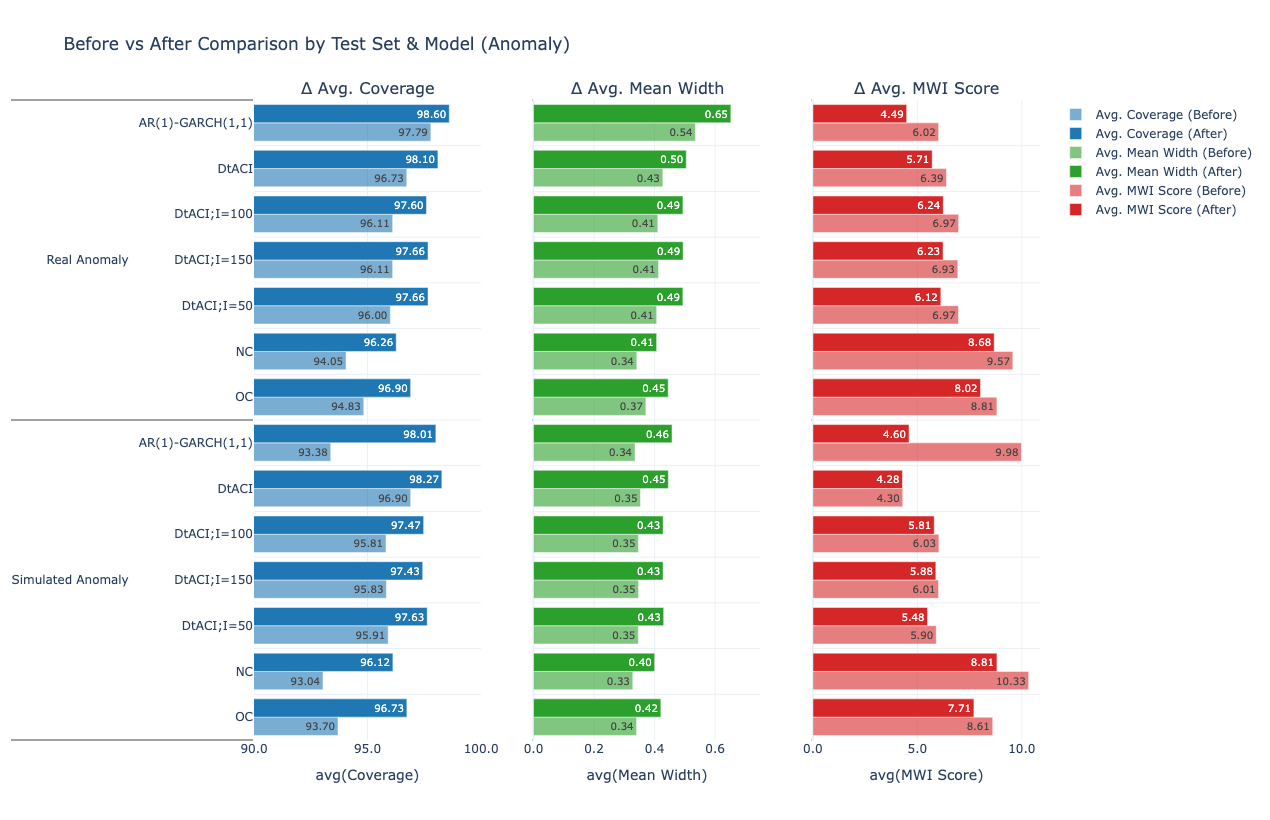

In [87]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

categories_inner = ordered_names
categories_outer = anom_chart_df['test_set'].unique().tolist()[::-1]
categories_outer = [c for c in categories_outer if c != 'Simulated DistShift+Anom 700']

values_cov_before = []
values_cov_after = []
values_width_before = []
values_width_after = []
values_mwi_before, values_mwi_after = [], []
values_cwc_before, values_cwc_after = [], []
y_outer = []
y_inner = []

for outer in categories_outer:
    for inner in categories_inner:
        value_row = anom_chart_df[
            (anom_chart_df['test_set'] == outer) &
            (anom_chart_df['model_name'] == inner)
        ]
        if value_row.empty:
            continue

        values_cov_before.append(value_row['mean_before_coverage'].iloc[0])
        values_cov_after.append(value_row['mean_after_coverage'].iloc[0])
        
        values_width_before.append(value_row['mean_before_avg_width'].iloc[0])
        values_width_after.append(value_row['mean_after_avg_width'].iloc[0])
        
        values_mwi_before.append(value_row['mean_before_mwi_score'].iloc[0])
        values_mwi_after.append(value_row['mean_after_mwi_score'].iloc[0])
        
        values_cwc_before.append(value_row['mean_before_cwc_score'].iloc[0])
        values_cwc_after.append(value_row['mean_after_cwc_score'].iloc[0])
        

        y_outer.append(outer.replace(" 700", ""))
        y_inner.append(inner.split(" + ")[0].replace(": Residual Normalized Score", ""))

# === Plot ===
fig = make_subplots(
    rows=1, cols=3, shared_yaxes=True,
    subplot_titles=("Δ Avg. Coverage", "Δ Avg. Mean Width", "Δ Avg. MWI Score")
)

# Coverage bars
fig.add_trace(go.Bar(
    x=values_cov_before,
    y=[y_outer, y_inner],
    orientation='h',
    name='Avg. Coverage (Before)',
    marker_color='rgba(31, 119, 180, 0.6)',
    text=[f"{v:.2f}" for v in values_cov_before],
    textposition='auto'
), row=1, col=1)

fig.add_trace(go.Bar(
    x=values_cov_after,
    y=[y_outer, y_inner],
    orientation='h',
    name='Avg. Coverage (After)',
    marker_color='rgba(31, 119, 180, 1.0)',
    text=[f"{v:.2f}" for v in values_cov_after],
    textposition='auto'
), row=1, col=1)

# Avg Width bars
fig.add_trace(go.Bar(
    x=values_width_before,
    y=[y_outer, y_inner],
    orientation='h',
    name='Avg. Mean Width (Before)',
    marker_color='rgba(44, 160, 44, 0.6)',
    text=[f"{v:.2f}" for v in values_width_before],
    textposition='auto'
), row=1, col=2)

fig.add_trace(go.Bar(
    x=values_width_after,
    y=[y_outer, y_inner],
    orientation='h',
    name='Avg. Mean Width (After)',
    marker_color='rgba(44, 160, 44, 1.0)',
    text=[f"{v:.2f}" for v in values_width_after],
    textposition='auto'
), row=1, col=2)

# Avg MWI score bars
fig.add_trace(go.Bar(
    x=values_mwi_before,
    y=[y_outer, y_inner],
    orientation='h',
    name='Avg. MWI Score (Before)',
    marker_color='rgba(214, 39, 40, 0.6) ',
    text=[f"{v:.2f}" for v in values_mwi_before],
    textposition='auto'
), row=1, col=3)

fig.add_trace(go.Bar(
    x=values_mwi_after,
    y=[y_outer, y_inner],
    orientation='h',
    name='Avg. MWI Score (After)',
    marker_color='rgba(214, 39, 40, 1.0) ',
    text=[f"{v:.2f}" for v in values_mwi_after],
    textposition='auto'
), row=1, col=3)


# Layout
fig.update_layout(
    height=820,
    width=1100,
    barmode='group',
    showlegend=True,
    template='plotly_white',
    title_text=f"Before vs After Comparison by Test Set & Model (Anomaly)"
)

fig.update_xaxes(title_text='avg(Coverage)', row=1, col=1, tickformat=".1f", range=[90,100])
fig.update_xaxes(title_text='avg(Mean Width)', row=1, col=2, tickformat=".1f", range=[0,0.75])
fig.update_xaxes(title_text='avg(MWI Score)', row=1, col=3, tickformat=".1f")
fig.update_yaxes(showgrid=True)

fig.show()


## Distribution Shift Eval

In [109]:
test_set_name = 'Simulated DistShift+Anom 700'
distshift_df = pd.read_sql(eval_template.format(test_set=test_set_name), conn)

In [110]:
query_dict = {}
for row in distshift_df[["model", "base_model"]].drop_duplicates().to_numpy():
    key = row[0] + " + " + str(row[1])
    query_dict[key] = {'dataset': None, 'model': None, 'conformity_score': None, 'conformal_mode': None}

In [111]:
# DEFINE EACH OF THESE COMBINATIONS
# 1. 'AR(1)-GARCH(1,1) + None'
query_dict['AR(1)-GARCH(1,1) + None']['dataset'] = 'argarch_results'
query_dict['AR(1)-GARCH(1,1) + None']['model'] = 'AR(1)-GARCH(1,1)'

# 1.2. DtACI: Gamma Score + AR(1)-GARCH(1,1)
query_dict['DtACI: Gamma Score + AR(1)']['dataset'] = 'dtaci_results_new'
query_dict['DtACI: Gamma Score + AR(1)']['model'] = 'AR(1)'
query_dict['DtACI: Gamma Score + AR(1)']['conformity_score'] = 'gamma'

# 2. DtACI: Residual Normalized Score + AR(1)-GARCH(1,1)
query_dict['DtACI: Residual Normalized Score + AR(1)-GARCH(1,1)']['dataset'] = 'dtaci_results_new'
query_dict['DtACI: Residual Normalized Score + AR(1)-GARCH(1,1)']['model'] = 'AR(1)-GARCH(1,1)'
query_dict['DtACI: Residual Normalized Score + AR(1)-GARCH(1,1)']['conformity_score'] = 'residual_normalized'

# 3. DtACI: Residual Normalized Score;I=100 + AR(1)-GARCH(1,1)
query_dict['DtACI: Residual Normalized Score;I=100 + AR(1)-GARCH(1,1)']['dataset'] = 'dtaci_results_new'
query_dict['DtACI: Residual Normalized Score;I=100 + AR(1)-GARCH(1,1)']['model'] = 'AR(1)-GARCH(1,1);I=100'
query_dict['DtACI: Residual Normalized Score;I=100 + AR(1)-GARCH(1,1)']['conformity_score'] = 'residual_normalized'

# 4. DtACI: Residual Normalized Score;I=150 + AR(1)-GARCH(1,1)
query_dict['DtACI: Residual Normalized Score;I=150 + AR(1)-GARCH(1,1)']['dataset'] = 'dtaci_results_new'
query_dict['DtACI: Residual Normalized Score;I=150 + AR(1)-GARCH(1,1)']['model'] = 'AR(1)-GARCH(1,1);I=150'
query_dict['DtACI: Residual Normalized Score;I=150 + AR(1)-GARCH(1,1)']['conformity_score'] = 'residual_normalized'

# 5. DtACI: Residual Normalized Score;I=50 + AR(1)-GARCH(1,1)
query_dict['DtACI: Residual Normalized Score;I=50 + AR(1)-GARCH(1,1)']['dataset'] = 'dtaci_results_new'
query_dict['DtACI: Residual Normalized Score;I=50 + AR(1)-GARCH(1,1)']['model'] = 'AR(1)-GARCH(1,1);I=50'
query_dict['DtACI: Residual Normalized Score;I=50 + AR(1)-GARCH(1,1)']['conformity_score'] = 'residual_normalized'

# 6. NC: Gamma Score + AR(1)
query_dict['NC: Gamma Score + AR(1)']['dataset'] = 'conformal_results'
query_dict['NC: Gamma Score + AR(1)']['conformal_mode'] = 'naive'
query_dict['NC: Gamma Score + AR(1)']['conformity_score'] = 'gamma'

# 7. NC: Residual Normalized Score + AR(1)-GARCH(1,1)
query_dict['NC: Residual Normalized Score + AR(1)-GARCH(1,1)']['dataset'] = 'conformal_results'
query_dict['NC: Residual Normalized Score + AR(1)-GARCH(1,1)']['conformal_mode'] = 'naive'
query_dict['NC: Residual Normalized Score + AR(1)-GARCH(1,1)']['conformity_score'] = 'residual_normalized'

# 8. OC: Gamma Score + AR(1)
query_dict['OC: Gamma Score + AR(1)']['dataset'] = 'conformal_results'
query_dict['OC: Gamma Score + AR(1)']['conformal_mode'] = 'online'
query_dict['OC: Gamma Score + AR(1)']['conformity_score'] = 'gamma'

# 9. OC: Residual Normalized Score + AR(1)-GARCH(1,1)
query_dict['OC: Residual Normalized Score + AR(1)-GARCH(1,1)']['dataset'] = 'conformal_results'
query_dict['OC: Residual Normalized Score + AR(1)-GARCH(1,1)']['conformal_mode'] = 'online'
query_dict['OC: Residual Normalized Score + AR(1)-GARCH(1,1)']['conformity_score'] = 'residual_normalized'

In [112]:
from data_simulator import get_reference_data
from model_fitting import ModelFitting

def get_distshift_performance(symbol, start_dt, end_dt, model_name, conformal_mode, conformity_score, 
                            dataset, model, test_set, distshift_idx = 200, distshift_dt = '2020-02-03', mkt_utils=mkt_utils):

    model_query = """
        select t.* 
        from {table} t
        where test_set = '{test_set}'
        and symbol = '{symbol}'
    """
    formatted_query = model_query.format(table=dataset, test_set = test_set, symbol=symbol)
    if conformal_mode is not None:
        formatted_query += f" and conformal_mode = '{conformal_mode}'"
    if conformity_score is not None:
        formatted_query += f" and conformity_score = '{conformity_score}'"
    if model is not None:
        formatted_query += f" and model = '{model}'"
    formatted_query += " order by t.'index' asc"

    # get data
    model_df = pd.read_sql(formatted_query, conn)
    # print(formatted_query)

    if test_set == "Real Distribution Shift":
        ref_data = get_reference_data(symbol=symbol, start_dt = start_dt, end_dt=end_dt, mkt_utils=mkt_utils)[0]
        
        sub_ref_df = ref_data[-len(model_df):].reset_index(drop=True)
        model_df_dt = model_df.merge(sub_ref_df[["dlycaldt"]], left_index=True, right_index=True)
        
        # Find the index of the row with 1
        distshift_idx = model_df_dt.index[model_df_dt['dlycaldt'].astype(str) == distshift_dt][0]
        
        # Split into two datasets
        before = model_df_dt.loc[:distshift_idx-1]      # rows before the 1
        after = model_df_dt.loc[distshift_idx:]     # rows after the 1
    else: # synthetic test set
        # Split into two datasets
        before = model_df.loc[:distshift_idx-1]      # rows before the 1
        after = model_df.loc[distshift_idx:]     # rows after the 1

        model_df_dt = model_df.copy()

    
    # create ModelFitting object
    m_fitting = ModelFitting(None)

    actual_range = max(before['actual'].max(), after['actual'].max()) - min(before['actual'].min(), after['actual'].min())

    # before stats
    before_stats = m_fitting.get_coverage_stats(before, actual_range = actual_range)
    before_stats = {f"before_{k}": v for k, v in before_stats.items()}

    # after stats
    after_stats = m_fitting.get_coverage_stats(after, actual_range = actual_range)
    after_stats = {f"after_{k}": v for k, v in after_stats.items()}

    # combined stats
    combined_stats = before_stats | after_stats
    
    combined_stats["symbol"] = symbol
    combined_stats["start_dt"] = start_dt
    combined_stats["end_dt"] = end_dt
    combined_stats["model_name"] = model_name

    return combined_stats

In [113]:
from tqdm import tqdm 

distshift_results = []
for ind, row in tqdm(distshift_df.iterrows()):
    # if ind == 70:
    model_name = row['model'] + " + " + str(row['base_model'])
    distshift_performance_dict = get_distshift_performance(row['symbol'], start_dt=row['start_dt'], end_dt=row['end_dt'], model_name=model_name, 
                                                    conformal_mode = query_dict[model_name]['conformal_mode'], 
                                                    conformity_score = query_dict[model_name]['conformity_score'], 
                                                    dataset = query_dict[model_name]['dataset'], 
                                                    model = query_dict[model_name]['model'], test_set=test_set_name)
    distshift_results.append(distshift_performance_dict)

1200it [00:58, 20.55it/s]


In [114]:
distshift_results_df = pd.DataFrame(distshift_results) #.drop(columns = ['index'])
distshift_results_df['test_set'] = test_set_name 
distshift_results_df.head()

,before_coverage,before_target_coverage,before_avg_width,before_median_width,before_max_width,before_mwi_score,before_cwc_score,before_min_width,before_R,before_mae,...,after_cwc_score,after_min_width,after_R,after_mae,after_rmse,symbol,start_dt,end_dt,model_name,test_set
0,94.0,95.0,0.432641,0.421425,0.716199,20.483373,1.145946,0.357649,11.483962,0.888165,...,0.489552,0.394227,11.483962,0.912937,1.248206,116052978254|std=7;8,1900-01-01,1900-08-30,"AR(1)-GARCH(1,1) + None",Simulated DistShift+Anom 700
1,94.5,95.0,0.331440,0.334616,0.352679,13.438710,0.757017,0.289738,9.995993,0.647425,...,0.458158,0.323139,9.995993,0.831406,1.133960,117212083233|std=7;8,1900-01-01,1900-08-30,"AR(1)-GARCH(1,1) + None",Simulated DistShift+Anom 700
2,94.0,95.0,0.623234,0.624389,0.649667,13.309635,1.650774,0.599522,5.479553,0.700799,...,0.624963,0.595771,5.479553,0.680378,0.859714,117441259785|std=8;9,1900-01-01,1900-08-30,"AR(1)-GARCH(1,1) + None",Simulated DistShift+Anom 700
3,92.0,95.0,0.426498,0.426158,0.439323,19.468139,2.337931,0.390964,7.363928,0.647023,...,1.221834,0.435397,7.363928,0.655320,0.863845,138529449215|std=5;6,1900-01-01,1900-08-30,"AR(1)-GARCH(1,1) + None",Simulated DistShift+Anom 700
4,94.0,95.0,0.449226,0.448026,0.501715,16.819738,1.189874,0.397226,4.648316,0.450290,...,0.486670,0.449224,4.648316,0.427848,0.561870,143235535694|std=6;7,1900-01-01,1900-08-30,"AR(1)-GARCH(1,1) + None",Simulated DistShift+Anom 700


In [115]:
distshift_results_df.to_sql("distshift_results_analysis", if_exists='append', index=False, con=conn)

1200

#### Plot

In [80]:
anom_chart_df = pd.read_sql("""
select test_set, 
       model_name,
       --substr(symbol, instr(symbol, 'std=') + 4) as std_category, 
       avg(before_coverage) as mean_before_coverage,
       avg(after_coverage) as mean_after_coverage,
       avg(before_avg_width) as mean_before_avg_width,
       avg(after_avg_width) as mean_after_avg_width,
       avg(before_mwi_score) as mean_before_mwi_score,
       avg(after_mwi_score) as mean_after_mwi_score
from distshift_results_analysis
where model_name not like '%Gamma%'
group by 1, 2 -- 3
""", conn)


In [81]:
ordered_names, _ = get_ordered_models(anom_chart_df, 'model_name')

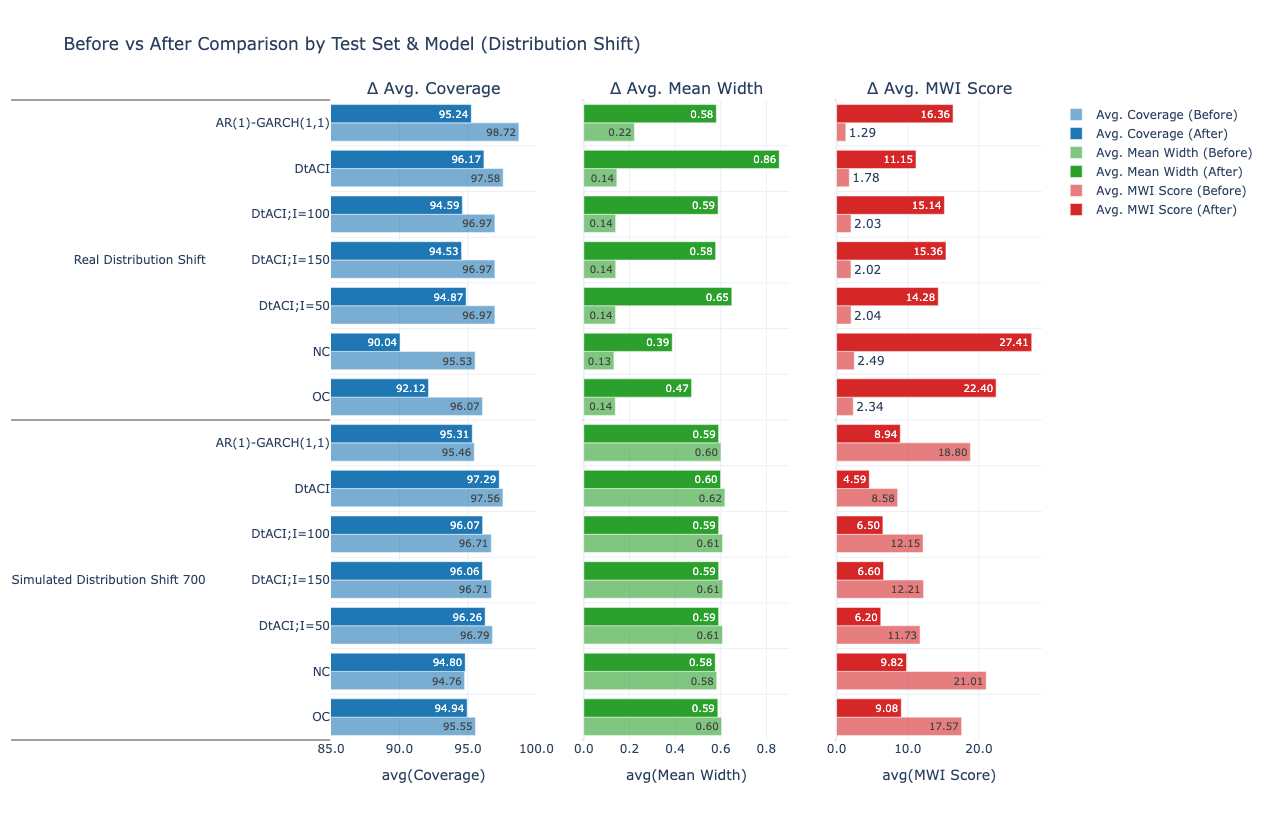

In [83]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

categories_inner = ordered_names
categories_outer = anom_chart_df['test_set'].unique().tolist()[::-1]
categories_outer = [c for c in categories_outer if c != 'Simulated DistShift+Anom 700']

values_cov_before = []
values_cov_after = []
values_width_before = []
values_width_after = []
values_mwi_before, values_mwi_after = [], []
y_outer = []
y_inner = []

for outer in categories_outer:
    for inner in categories_inner:
        value_row = anom_chart_df[
            (anom_chart_df['test_set'] == outer) &
            (anom_chart_df['model_name'] == inner)
        ]
        if value_row.empty:
            continue

        values_cov_before.append(value_row['mean_before_coverage'].iloc[0])
        values_cov_after.append(value_row['mean_after_coverage'].iloc[0])
        
        values_width_before.append(value_row['mean_before_avg_width'].iloc[0])
        values_width_after.append(value_row['mean_after_avg_width'].iloc[0])
        
        values_mwi_before.append(value_row['mean_before_mwi_score'].iloc[0])
        values_mwi_after.append(value_row['mean_after_mwi_score'].iloc[0])
        

        y_outer.append(outer)
        y_inner.append(inner.split(" + ")[0].replace(": Residual Normalized Score", ""))

# === Plot ===
fig = make_subplots(
    rows=1, cols=3, shared_yaxes=True,
    subplot_titles=("Δ Avg. Coverage", "Δ Avg. Mean Width", "Δ Avg. MWI Score")
)

# Coverage bars
fig.add_trace(go.Bar(
    x=values_cov_before,
    y=[y_outer, y_inner],
    orientation='h',
    name='Avg. Coverage (Before)',
    marker_color='rgba(31, 119, 180, 0.6)',
    text=[f"{v:.2f}" for v in values_cov_before],
    textposition='auto'
), row=1, col=1)

fig.add_trace(go.Bar(
    x=values_cov_after,
    y=[y_outer, y_inner],
    orientation='h',
    name='Avg. Coverage (After)',
    marker_color='rgba(31, 119, 180, 1.0)',
    text=[f"{v:.2f}" for v in values_cov_after],
    textposition='auto'
), row=1, col=1)

# Avg Width bars
fig.add_trace(go.Bar(
    x=values_width_before,
    y=[y_outer, y_inner],
    orientation='h',
    name='Avg. Mean Width (Before)',
    marker_color='rgba(44, 160, 44, 0.6)',
    text=[f"{v:.2f}" for v in values_width_before],
    textposition='auto'
), row=1, col=2)

fig.add_trace(go.Bar(
    x=values_width_after,
    y=[y_outer, y_inner],
    orientation='h',
    name='Avg. Mean Width (After)',
    marker_color='rgba(44, 160, 44, 1.0)',
    text=[f"{v:.2f}" for v in values_width_after],
    textposition='auto'
), row=1, col=2)

# Avg MWI score bars
fig.add_trace(go.Bar(
    x=values_mwi_before,
    y=[y_outer, y_inner],
    orientation='h',
    name='Avg. MWI Score (Before)',
    marker_color='rgba(214, 39, 40, 0.6) ',
    text=[f"{v:.2f}" for v in values_mwi_before],
    textposition='auto'
), row=1, col=3)

fig.add_trace(go.Bar(
    x=values_mwi_after,
    y=[y_outer, y_inner],
    orientation='h',
    name='Avg. MWI Score (After)',
    marker_color='rgba(214, 39, 40, 1.0) ',
    text=[f"{v:.2f}" for v in values_mwi_after],
    textposition='auto'
), row=1, col=3)


# Layout
fig.update_layout(
    height=820,
    width=1100,
    barmode='group',
    showlegend=True,
    template='plotly_white',
    title_text=f"Before vs After Comparison by Test Set & Model (Distribution Shift)"
)

fig.update_xaxes(title_text='avg(Coverage)', row=1, col=1, tickformat=".1f", range=[85,100])
fig.update_xaxes(title_text='avg(Mean Width)', row=1, col=2, tickformat=".1f", range=[0,0.9])
fig.update_xaxes(title_text='avg(MWI Score)', row=1, col=3, tickformat=".1f")
fig.update_yaxes(showgrid=True)

fig.show()

#### Simulated Anomaly + Distribution Shift Set

In [116]:
sim_anom_chart_df = pd.read_sql("""
select test_set, 
       model_name,
       substr(symbol, instr(symbol, 'std=') + 4) as std_category, 
       avg(before_coverage) as mean_before_coverage,
       avg(after_coverage) as mean_after_coverage,
       avg(before_avg_width) as mean_before_avg_width,
       avg(after_avg_width) as mean_after_avg_width,
       avg(before_mwi_score) as mean_before_mwi_score,
       avg(after_mwi_score) as mean_after_mwi_score
from distshift_results_analysis
where model_name not like '%Gamma%'
and test_set = 'Simulated DistShift+Anom 700'
group by 1, 2, 3
""", conn)

In [117]:
sim_anom_chart_df

,test_set,model_name,std_category,mean_before_coverage,mean_after_coverage,mean_before_avg_width,mean_after_avg_width,mean_before_mwi_score,mean_after_mwi_score
0,Simulated DistShift+Anom 700,"AR(1)-GARCH(1,1) + None",5;6,95.550000,96.533333,0.365913,0.419776,10.400652,14.320902
1,Simulated DistShift+Anom 700,"AR(1)-GARCH(1,1) + None",6;7,95.900000,96.350000,0.401364,0.436799,13.199793,15.885774
2,Simulated DistShift+Anom 700,"AR(1)-GARCH(1,1) + None",7;8,94.900000,96.033333,0.352166,0.398288,11.959782,16.694463
3,Simulated DistShift+Anom 700,"AR(1)-GARCH(1,1) + None",8;9,95.733333,96.466667,0.375645,0.434627,11.845522,15.187990
4,Simulated DistShift+Anom 700,DtACI: Residual Normalized Score + AR(1)-GARCH...,5;6,96.733333,96.300000,0.370058,0.394501,5.964747,13.139502
5,Simulated DistShift+Anom 700,DtACI: Residual Normalized Score + AR(1)-GARCH...,6;7,96.550000,96.500000,0.398488,0.409513,9.286685,13.911356
6,Simulated DistShift+Anom 700,DtACI: Residual Normalized Score + AR(1)-GARCH...,7;8,97.050000,96.300000,0.368563,0.388813,5.626790,14.418683
7,Simulated DistShift+Anom 700,DtACI: Residual Normalized Score + AR(1)-GARCH...,8;9,96.900000,96.366667,0.385113,0.407272,6.994594,14.592030
8,Simulated DistShift+Anom 700,DtACI: Residual Normalized Score;I=100 + AR(1)...,5;6,96.300000,96.200000,0.367986,0.393381,6.823033,13.304400
9,Simulated DistShift+Anom 700,DtACI: Residual Normalized Score;I=100 + AR(1)...,6;7,96.166667,96.166667,0.395831,0.408400,10.332280,14.254048


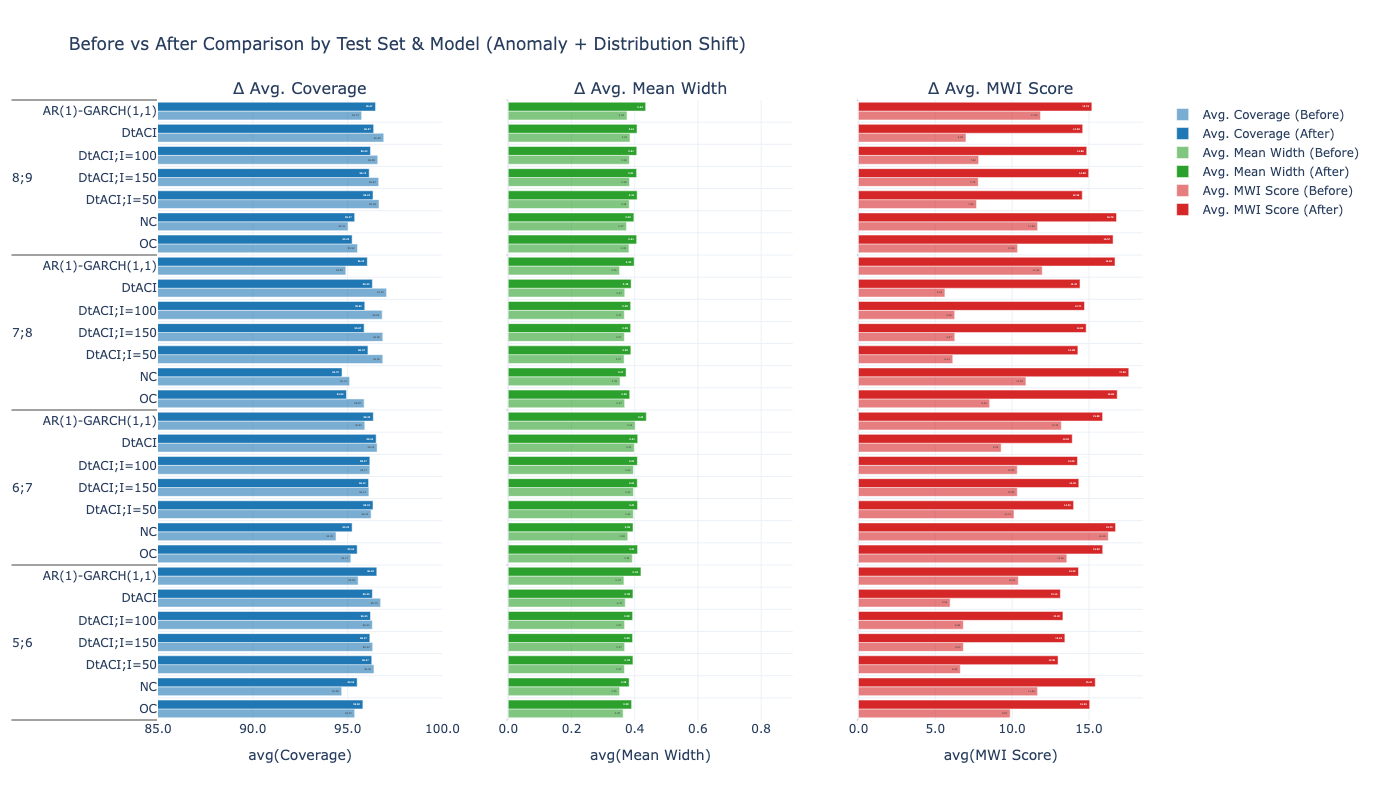

In [118]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

categories_inner = ordered_names
categories_outer = list(sim_anom_chart_df['std_category'].unique()) #sim_anom_chart_df['test_set'].unique().tolist()[::-1]

values_cov_before = []
values_cov_after = []
values_width_before = []
values_width_after = []
values_mwi_before, values_mwi_after = [], []
y_outer = []
y_inner = []

for outer in categories_outer:
    for inner in categories_inner:
        value_row = sim_anom_chart_df[
            (sim_anom_chart_df['std_category'] == outer) &
            (sim_anom_chart_df['model_name'] == inner)
        ]
        if value_row.empty:
            continue

        values_cov_before.append(value_row['mean_before_coverage'].iloc[0])
        values_cov_after.append(value_row['mean_after_coverage'].iloc[0])
        
        values_width_before.append(value_row['mean_before_avg_width'].iloc[0])
        values_width_after.append(value_row['mean_after_avg_width'].iloc[0])
        
        values_mwi_before.append(value_row['mean_before_mwi_score'].iloc[0])
        values_mwi_after.append(value_row['mean_after_mwi_score'].iloc[0])
        

        y_outer.append(outer)
        y_inner.append(inner.split(" + ")[0].replace(": Residual Normalized Score", ""))

# === Plot ===
fig = make_subplots(
    rows=1, cols=3, shared_yaxes=True,
    subplot_titles=("Δ Avg. Coverage", "Δ Avg. Mean Width", "Δ Avg. MWI Score")
)

# Coverage bars
fig.add_trace(go.Bar(
    x=values_cov_before,
    y=[y_outer, y_inner],
    orientation='h',
    name='Avg. Coverage (Before)',
    marker_color='rgba(31, 119, 180, 0.6)',
    text=[f"{v:.2f}" for v in values_cov_before],
    textposition='auto'
), row=1, col=1)

fig.add_trace(go.Bar(
    x=values_cov_after,
    y=[y_outer, y_inner],
    orientation='h',
    name='Avg. Coverage (After)',
    marker_color='rgba(31, 119, 180, 1.0)',
    text=[f"{v:.2f}" for v in values_cov_after],
    textposition='auto'
), row=1, col=1)

# Avg Width bars
fig.add_trace(go.Bar(
    x=values_width_before,
    y=[y_outer, y_inner],
    orientation='h',
    name='Avg. Mean Width (Before)',
    marker_color='rgba(44, 160, 44, 0.6)',
    text=[f"{v:.2f}" for v in values_width_before],
    textposition='auto'
), row=1, col=2)

fig.add_trace(go.Bar(
    x=values_width_after,
    y=[y_outer, y_inner],
    orientation='h',
    name='Avg. Mean Width (After)',
    marker_color='rgba(44, 160, 44, 1.0)',
    text=[f"{v:.2f}" for v in values_width_after],
    textposition='auto'
), row=1, col=2)

# Avg MWI score bars
fig.add_trace(go.Bar(
    x=values_mwi_before,
    y=[y_outer, y_inner],
    orientation='h',
    name='Avg. MWI Score (Before)',
    marker_color='rgba(214, 39, 40, 0.6) ',
    text=[f"{v:.2f}" for v in values_mwi_before],
    textposition='auto'
), row=1, col=3)

fig.add_trace(go.Bar(
    x=values_mwi_after,
    y=[y_outer, y_inner],
    orientation='h',
    name='Avg. MWI Score (After)',
    marker_color='rgba(214, 39, 40, 1.0) ',
    text=[f"{v:.2f}" for v in values_mwi_after],
    textposition='auto'
), row=1, col=3)


# Layout
fig.update_layout(
    height=800,
    width=1100,
    barmode='group',
    showlegend=True,
    template='plotly_white',
    title_text=f"Before vs After Comparison by Test Set & Model (Anomaly + Distribution Shift)"
)

fig.update_xaxes(title_text='avg(Coverage)', row=1, col=1, tickformat=".1f", range=[85,100])
fig.update_xaxes(title_text='avg(Mean Width)', row=1, col=2, tickformat=".1f", range=[0,0.9])
fig.update_xaxes(title_text='avg(MWI Score)', row=1, col=3, tickformat=".1f")
fig.update_yaxes(showgrid=True)

fig.show()

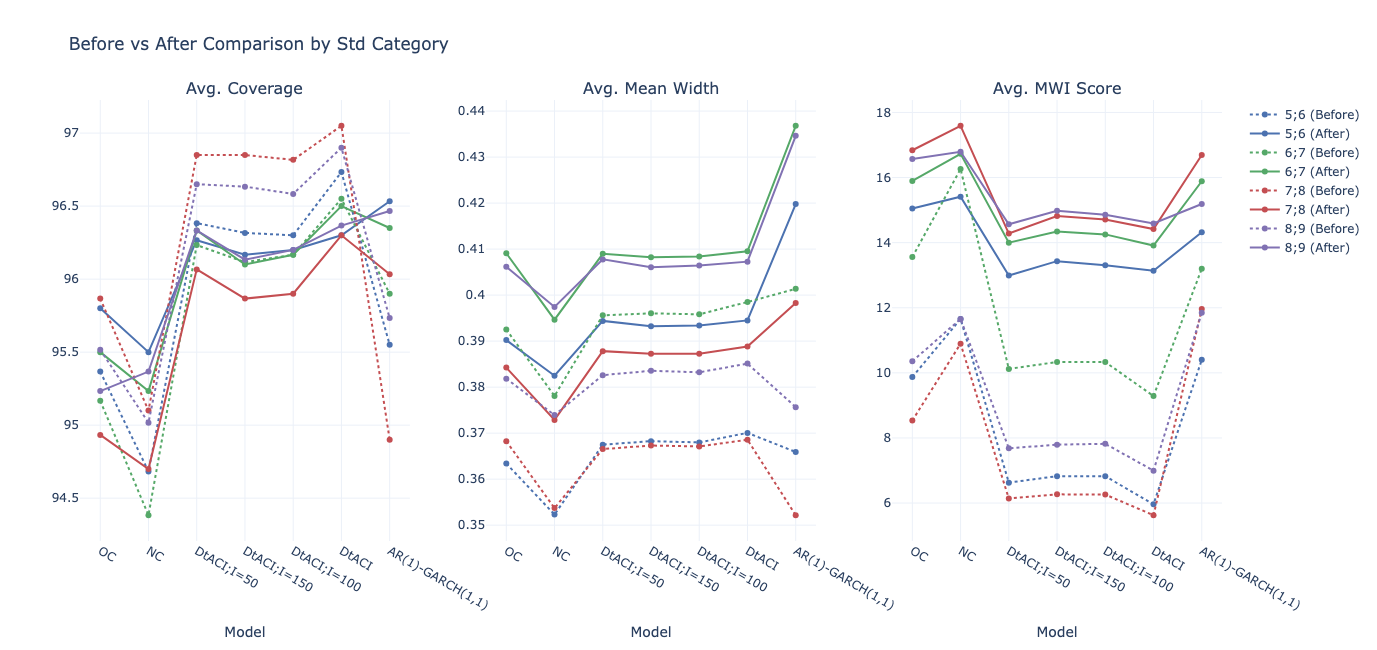

In [119]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Muted, distinct colors for each std_category
palette = [
    "#4C72B0",  # muted blue
    "#55A868",  # muted green
    "#C44E52",  # muted red
    "#8172B3",  # muted purple
    "#CCB974",  # muted mustard
    "#64B5CD"   # muted cyan
]

x_models = [m.split(" + ")[0].replace(": Residual Normalized Score", "") for m in categories_inner]

fig = make_subplots(
    rows=1, cols=3, shared_xaxes=True,
    subplot_titles=("Avg. Coverage", "Avg. Mean Width", "Avg. MWI Score")
)

for idx, outer in enumerate(categories_outer):
    color = palette[idx % len(palette)]

    cov_before, cov_after = [], []
    wid_before, wid_after = [], []
    mwi_before, mwi_after = [], []
    
    for inner in categories_inner:
        row = sim_anom_chart_df[
            (sim_anom_chart_df['std_category'] == outer) &
            (sim_anom_chart_df['model_name'] == inner)
        ]
        if row.empty:
            cov_before.append(None); cov_after.append(None)
            wid_before.append(None); wid_after.append(None)
            mwi_before.append(None); mwi_after.append(None)
            continue
        
        cov_before.append(row['mean_before_coverage'].iloc[0])
        cov_after.append(row['mean_after_coverage'].iloc[0])
        wid_before.append(row['mean_before_avg_width'].iloc[0])
        wid_after.append(row['mean_after_avg_width'].iloc[0])
        mwi_before.append(row['mean_before_mwi_score'].iloc[0])
        mwi_after.append(row['mean_after_mwi_score'].iloc[0])
    
    # Coverage
    fig.add_trace(go.Scatter(
        x=x_models, y=cov_before, mode='lines+markers',
        name=f"{outer} (Before)", line=dict(color=color, dash='dot')
    ), row=1, col=1)

    fig.add_trace(go.Scatter(
        x=x_models, y=cov_after, mode='lines+markers',
        name=f"{outer} (After)", line=dict(color=color)
    ), row=1, col=1)

    # Width
    fig.add_trace(go.Scatter(
        x=x_models, y=wid_before, mode='lines+markers',
        name=f"{outer} (Before)", showlegend=False,
        line=dict(color=color, dash='dot')
    ), row=1, col=2)

    fig.add_trace(go.Scatter(
        x=x_models, y=wid_after, mode='lines+markers',
        name=f"{outer} (After)", showlegend=False,
        line=dict(color=color)
    ), row=1, col=2)

    # MWI
    fig.add_trace(go.Scatter(
        x=x_models, y=mwi_before, mode='lines+markers',
        name=f"{outer} (Before)", showlegend=False,
        line=dict(color=color, dash='dot')
    ), row=1, col=3)

    fig.add_trace(go.Scatter(
        x=x_models, y=mwi_after, mode='lines+markers',
        name=f"{outer} (After)", showlegend=False,
        line=dict(color=color)
    ), row=1, col=3)

fig.update_layout(
    height=650,
    width=1300,
    template='plotly_white',
    title="Before vs After Comparison by Std Category"
)

fig.update_xaxes(title='Model', tickangle=30)
fig.update_yaxes(showgrid=True)

fig.show()


**Notes:**
- Incorporate error bars when presenting
- Only include 2-3 significant figures

## Synthetic anomaly results analysis

In [ ]:
get_data("Real Distribution Shift")

### Testing on sample symbol and date range

In [ ]:
ref_data = get_reference_data(symbol="BKCC", start_dt = "2014-04-03", end_dt="2015-12-09", mkt_utils=mkt_utils)[0]

In [ ]:
model_query = """
select t.* 
from {table} t
where test_set = '{test_set}'
and symbol = '{symbol}'
"""
model_df = pd.read_sql(model_query.format(table="argarch_results", test_set = "Simulated Anomaly 700", symbol="206838503019"), conn)
#sub_ref_df = ref_data[-len(model_df):].reset_index(drop=True)
#model_df_dt = model_df.merge(sub_ref_df[["dlycaldt"]], left_index=True, right_index=True)

In [ ]:
model_df[model_df["model"] == "AR(1)-GARCH(1,1)"]

In [ ]:
model_df_dt["anom_flag"] = 0

In [ ]:
model_df_dt

In [ ]:
real_anomaly_qry = """
select *
from manual_anomalies
where symbol = '{symbol}'
"""
real_anom_record = pd.read_sql(real_anomaly_qry.format(symbol="BKCC"), conn)

In [ ]:
model_df_dt.loc[model_df_dt['dlycaldt'].isin(real_anom_record["date"].unique()), 'anom_flag'] = 1

In [ ]:
model_df_dt[model_df_dt['anom_flag'] == 1]

In [ ]:
# Find the index of the row with 1
anom_idx = model_df_dt.index[model_df_dt['anom_flag'] == 1][0]

# Split into two datasets
before = model_df_dt.loc[:anom_idx-1]      # includes the 1
after = model_df_dt.loc[anom_idx + 1:]         # rows after the 1

**Metrics**
- Stats before
- Stats after

In [ ]:
from model_fitting import ModelFitting
m_fitting = ModelFitting(None)

In [ ]:
model_df_dt[~model_df_dt["within_CI"].astype(bool)]

In [ ]:
~model_df_dt["within_CI"].astype(bool)

In [ ]:
m_fitting.get_coverage_stats(before)

In [ ]:
m_fitting.get_coverage_stats(after)